In [1]:
import jax
import jax.numpy as jnp
from jax import device_put

In [2]:
import pennylane as qml
import numpy as np
from IPython import display
import time
import matplotlib.pyplot as plt
from math import sqrt,pi
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import optax

In [3]:
#seeds used for random functions
from jax import random
key = random.PRNGKey(999)
np.random.seed(999)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# data generation: rps model

Below we generate the RPS data set as described in the manuscript.

first we construct a 'points' matricies for each pair of players, where a point is awarded if a player beats another and deducted if they are beaten: `A[i,j]` gives the points awarded to player i when playing player j for each of the 9 possible pairs of actions. 

In [4]:
A=np.zeros([3,3,3,3])
A[0,1]=np.array([[1,-1,1],[1,-1,-1],[-1,1,0]])
A[0,2]=np.array([[1,-1,1],[1,0,-1],[-1,1,-1]])
A[1,2]=np.array([[0,-1,1],[1,1,-1],[-1,1,-1]])
A[1,0]=-A[0,1].T
A[2,0]=-A[0,2].T
A[2,1]=-A[1,2].T
A = jnp.array(A)

In [5]:
def get_payoff_probs(X):
    """
    get the payoff probabilities for each player given a strategy X
    """
    points0 = jnp.matmul(jnp.matmul(X[0],A[0,1]),X[1])+jnp.matmul(jnp.matmul(X[0],A[0,2]),X[2])
    points1 = jnp.matmul(jnp.matmul(X[1],A[1,0]),X[0])+jnp.matmul(jnp.matmul(X[1],A[1,2]),X[2])
    points2 = jnp.matmul(jnp.matmul(X[2],A[2,0]),X[0])+jnp.matmul(jnp.matmul(X[2],A[2,1]),X[1])
    probs = jnp.array([points0,points1,points2])
    return (probs/2+1)/2

#JAX vectorisation
vpayoff_probs = jax.vmap(get_payoff_probs,0)

In [6]:
def get_strat_mat(N):
    """
    This generates N strategy matrices, normalised by row
    """
    pmat = np.random.rand(N,3,3)
    for i in range(N):
        for k in range(3):
            pmat[i,k]=pmat[i,k]/np.sum(pmat[i,k])
    return pmat

def generate_data(N):
    X = get_strat_mat(N) #strategies
    P = vpayoff_probs(X) #payoff probabilities
    r=np.random.rand(*P.shape) 
    Y = np.where(P>r,0,1) #sampled payoffs for data labels
    return X, Y, P


# Define learning models

Here we define the quantum and surrogate models

In [7]:
#some functions used to cosntruct the quantum models

def swap_rot(x,wires):
    #two qubit rotation with swap matrix as generator 
    #(identiy is not included since it adds a global phase)
    qml.PauliRot(x,'XX',wires=wires)
    qml.PauliRot(x,'YY',wires=wires)
    qml.PauliRot(x,'ZZ',wires=wires)
    
def data_encoding(x):
    #S_x^1 in paper
    for q in range(3):
        qml.RZ(x[q],wires=q)

def data_encoding_pairs(x):
    #S_x^2 in paper
    qml.PauliRot(x[0]*x[1],'ZZ',wires=[0,1])
    qml.PauliRot(x[1]*x[2],'ZZ',wires=[1,2])
    qml.PauliRot(x[0]*x[2],'ZZ',wires=[0,2])
    
def state_prep(alpha):
    #V in paper for biased model
    qml.RY(alpha[0],wires=0)
    qml.RY(alpha[0]+pi,wires=1) 
    
def layer_q(weights,blocks):
    #U in paper for the biased model
    for b in range(blocks):
        for q in range(3):
            qml.RZ(weights[b,q],wires=q)
            qml.PauliRot(weights[b,3],'ZZ',wires=[0,1])
            qml.PauliRot(weights[b,4],'ZZ',wires=[0,2])
            qml.PauliRot(weights[b,5],'ZZ',wires=[1,2])
        swap_rot(weights[b,6],wires=[0,1])
        swap_rot(weights[b,7],wires=[1,2])
        swap_rot(weights[b,8],wires=[0,2])
        
def layer_u(weights,blocks):
    #U in paper for the unbiased model
    for b in range(blocks):
        for q in range(3):
            qml.Rot(weights[b,3*q],weights[b,3*q+1],weights[b,3*q+2],wires=q)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,1])

def layer_u_fixed(weights,blocks):
    #U in paper for the unbiased model
    for b in range(blocks):
        for q in range(3):
            qml.Rot(weights[b,3*q],weights[b,3*q+1],weights[b,3*q+2],wires=q)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[1,2])
        qml.CNOT(wires=[0,2])
       

## Quantum models

Define the two quantum model classes (biased and unbiased)

In [8]:
def get_q_model(basic=False):
    #The biased quantum model
    dev = qml.device('default.qubit',wires=3)
    @qml.qnode(dev, interface="jax")
    def model(weights,x,layers,blocks):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.Hadamard(wires=2)
        #we use the last layer of the weights array to store the parameter V
        state_prep(weights[2*layers+1,0])
        x1 = jnp.array([x[0,0],x[1,1],x[2,2]])
        x2 = jnp.array(([x[0,1]-x[0,2],x[1,2]-x[1,0],x[2,0]-x[2,1]]))
        for l in range(0,2*layers,2):
            layer_q(weights[l],blocks)
            data_encoding(x1)
            layer_q(weights[l+1],blocks)
            data_encoding_pairs(x2)
        layer_q(weights[2*layers],blocks)
        return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2))]
    #jax vectorisation, we vectorise over the data input (the second argument)
    vmodel = jax.vmap(model,(None,0,None,None))
    def vmodel_fixed(*args):
        return jnp.array(vmodel(*args)).T 
    return vmodel_fixed

def get_q_model_unstr(basic=False):
    #The unbiased quantum model
    dev = qml.device('default.qubit',wires=3)
    @qml.qnode(dev, interface="jax")
    def model(weights,x,layers,blocks):
        x1 = jnp.array([x[0,0],x[1,1],x[2,2]])
        x2 = jnp.array([x[0,1]-x[0,2],x[1,2]-x[1,0],x[2,0]-x[2,1]])
        for l in range(0,layers*2,2):
            layer_u(weights[l],blocks)
            data_encoding(x1)
            layer_u(weights[l+1],blocks)
            data_encoding_pairs(x2)
        layer_u(weights[2*layers],blocks)
        return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2))]
    vmodel = jax.vmap(model,(None,0,None,None))
    def vmodel_fixed(*args):
        return jnp.array(vmodel(*args)).T 
    return vmodel_fixed

def get_fixed_q_model_unstr(basic=False):
    #The unbiased quantum model
    dev = qml.device('default.qubit',wires=3)
    @qml.qnode(dev, interface="jax")
    def model(weights,x,layers,blocks):
        x1 = jnp.array([x[0,0],x[1,1],x[2,2]])
        x2 = jnp.array([x[0,1]-x[0,2],x[1,2]-x[1,0],x[2,0]-x[2,1]])
        for l in range(0,layers*2,2):
            layer_u_fixed(weights[l],blocks)
            data_encoding(x1)
            layer_u_fixed(weights[l+1],blocks)
            data_encoding_pairs(x2)
        layer_u_fixed(weights[2*layers],blocks)
        return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2))]
    vmodel = jax.vmap(model,(None,0,None,None))
    def vmodel_fixed(*args):
        return jnp.array(vmodel(*args)).T 
    return vmodel_fixed

def get_fair_unbaised_model1(basic=False):
    ## exact baised quantum model with hadamards in beginning replaced by learnable 1 param rotation
    dev = qml.device('default.qubit',wires=3)
    @qml.qnode(dev, interface="jax")
    def model(weights,x,layers,blocks):
        for i in range(3):
            qml.RX(weights[2*layers+2, 0, i], wires=i)
        #we use the last layer of the weights array to store the parameter V
        state_prep(weights[2*layers+1,0])
        x1 = jnp.array([x[0,0],x[1,1],x[2,2]])
        x2 = jnp.array(([x[0,1]-x[0,2],x[1,2]-x[1,0],x[2,0]-x[2,1]]))
        for l in range(0,2*layers,2):
            layer_u_fixed(weights[l],blocks)
            data_encoding(x1)
            layer_u_fixed(weights[l+1],blocks)
            data_encoding_pairs(x2)
        layer_u_fixed(weights[2*layers],blocks)
        return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2))]
    #jax vectorisation, we vectorise over the data input (the second argument)
    vmodel = jax.vmap(model,(None,0,None,None))
    def vmodel_fixed(*args):
        return jnp.array(vmodel(*args)).T 
    return vmodel_fixed

## Surroagte models

Define the surrogate model class

In [9]:
def get_freqs(nvars,spectrum):
        """
        Get the array of all possible frequencies omega appearing in the truncated fourier series
        Where the number of data variables is nvars, and the largest value of any component of 
        omega is spectrum. 
        """
        nlambda = 2*spectrum+1
        freqs= [jnp.unravel_index(i,[nlambda for __ in range(nvars)]) for i in range(nlambda**nvars)]
        freqs = jnp.array(freqs)
        freqs=freqs-spectrum
        return freqs

def get_surrogate_model():
    def surrogate(weights,x,freqs,arg2=0):
        x1 = jnp.array([x[0,0],x[1,1],x[2,2]])
        x2 = jnp.array([x[0,1]-x[0,2],x[1,2]-x[1,0],x[2,0]-x[2,1]])
        variables = jnp.concatenate((x1,
                                    jnp.array([x2[0]*x2[1] ,x2[1]*x2[2], x2[0]*x2[2]])))
        #get all the omega*x values appearing in the fourier sum
        z = jnp.sum(freqs*variables.flatten(),axis=1)
        waves_cos = jnp.cos(z)
        waves_sin = jnp.sin(z)
        #build the linear models for each component via matrix multiplication
        y=jnp.matmul(weights,jnp.hstack([waves_cos,waves_sin]))
        #below implements the hardtanh function
        signs = jnp.sign(y)
        y=jnp.abs(y)
        y=jnp.vstack([y,jnp.ones(3)])
        y=jnp.min(y,axis=0)
        y=y*signs
        return  y
    #JAX vectorisation
    vsurrogate = jax.vmap(surrogate,(None,0,None,None))

    return vsurrogate


Some functions used in training an evaluation

In [10]:
def kl_div(p,q):
    """
    Get the KL divergence between two probability distribtuions
    """
    p=jnp.vstack([p,jnp.ones(len(p))*10**(-8)]) #lower cutoff of prob values of 10e-8
    p=jnp.max(p,axis=0)
    return jnp.sum(q*jnp.log(q/p)) #forward kl div 

def kl_mean(probs,probs0):
    """
    get the mean KL divergence of the three marginal distributions
    """
    kl = 0
    for t in range(3):
        kl=kl+kl_div(probs[t,:],probs0[t,:])
    return kl/3

#vectorise kl_mean function, makes estimating the average KL diverence of a model faster.
vkl_mean = jax.vmap(kl_mean,(0,0))

def model_probs(model,X_test,weights,arg1,arg2):
    """
    Returns the marginal probabilties of a given model for a test data set X_test
    """
    probs = np.zeros([len(X_test),3,2])
    expvals = model(weights,X_test,arg1,arg2)
    for t in range(3):
        probs[:,t,0] = (1+expvals[:,t])/2
        probs[:,t,1] = (1-expvals[:,t])/2
    return probs

def likelihood(weights,X,Y,model,arg1,arg2,reg):
    """
    The cost function. Returns the negative log likelihood plus a L2  weight regularisation penalty
    """
    expvals = model(weights,X,arg1,arg2)
    probs = (1+(1-2*Y)*expvals)/2
    probs = jnp.log(probs)
    llh = jnp.sum(probs)/len(X)/3
    return -llh + jnp.sum(weights**2)*reg

def gen_test_set(N_test):
    """
    generates a test set of strategies
    """
    X_test = get_strat_mat(N_test)
    return X_test

def get_av_test_kl(model,weights,probs0,X_test,arg1,arg2):
    """
    returns the average KL divergence of a model for a test set X_test. 
    This is the figure of merit used to evaluate the generalisation performance.
    """
    N_test=len(X_test)
    probs = np.zeros(probs0.shape)
    expvals = model(weights,X_test,arg1,arg2)
    for t in range(3):
        probs[:,t,0] = (1+expvals[:,t])/2
        probs[:,t,1] = (1-expvals[:,t])/2
    return np.sum(vkl_mean(probs,probs0))/N_test



We use the optax library to optimise the models. For the quanutm model arg1 and arg2 correspond to L and B in the paper. For the surrogate model arg1 is an array containing all values of omega, and arg2 is unused. 

In [11]:
def optimise_model_adam(model,nstep,lr,weights,batchfrac=1.0,sgd=False,arg1=1,arg2=1,reg=0.):
    plot=[[],[],[]]
    X_test = gen_test_set(10000) #the test set for evaluation
    N_test=len(X_test)
    probs0 = np.zeros([N_test,3,2])
    probs0[:,:,0] = vpayoff_probs(X_test) #the true probabilities for the test set
    probs0[:,:,1] = 1-probs0[:,:,0]
    probs0=jnp.array(probs0)
    if sgd:
        optimizer = optax.sgd(lr)
    else:
        optimizer = optax.adam(lr) #this is default
    opt_state = optimizer.init(weights)
    steps = tqdm(range(nstep))
    for step in steps:
        #use optax to update parameters
        llh, grads = jax.value_and_grad(likelihood)(weights, X, Y, model,arg1,arg2,reg)
        updates, opt_state = optimizer.update(grads, opt_state, weights)
        weights = optax.apply_updates(weights, updates)
        if step%1==0:
            kl = get_av_test_kl(model,weights,probs0,X_test,arg1,arg2)
            steps.set_description("Current divergence: %s" % str(kl)+ " :::: "+
                                  "Current likelihood: %s" % str(llh))
        plot[0].append(step)
        plot[1].append(float(llh))
        plot[2].append(float(kl))
    return weights, llh, kl, plot

# Training

In [12]:
#generate data
N=1500 #number of data points

X = np.load('Xdata.npy')
Y = np.load('Ydata.npy')

X = jnp.array(X)
Y = jnp.array(Y)
# P = jnp.array(P)

X_copy = jnp.array(X)

#scale the data by pi/2
# scaling = pi/2
scaling = 1
X = scaling*jnp.array(X_copy)

#put the data on the GPU if there is one
X = device_put(X)
Y = device_put(Y)

In [13]:
n_steps = 2000 #number of optimisation steps
n_runs = 3 #number of runs (or trials)

layers_list = [2] #the possible values of L we consider for the quantum models
spectrum_list = [1,2] #the possible spectra we consider for the surrogate
reg = 0. #the L2 weight regularisation penalty coefficient
nvars=6 #the number of data variables in the fourier series of the surrogate model
blocks = 2 #the value of B in the paper

#arrays for storing the plot data
data_q = [np.zeros([n_runs,n_steps,3]) for __ in range(len(layers_list))]
data_u = [np.zeros([n_runs,n_steps,3]) for __ in range(len(layers_list))]
data_u_fixed = [np.zeros([n_runs,n_steps,3]) for __ in range(len(layers_list))]
data_u_fair = [np.zeros([n_runs,n_steps,3]) for __ in range(len(layers_list))]
data_s = [np.zeros([n_runs,n_steps,3]) for __ in range(len(spectrum_list))] 

## Train the models

### surragate model

In [14]:
for i,spectrum in enumerate(spectrum_list):
    n_freq = 2*(2*spectrum+1)**6
    freqs= get_freqs(nvars,spectrum)
    if spectrum==1:
        lr=0.001
    else:
        lr=0.0001
    vsurrogate = get_surrogate_model()
    vsurrogate=jax.jit(vsurrogate)
    # for run in range(n_runs):
    for run in range(1):
        weights_s = (2*np.random.rand(3,n_freq)-1)*1/n_freq
        weights_s = device_put(weights_s)
        weights_s, llh, kl, plot = optimise_model_adam(vsurrogate,n_steps,lr,weights_s,sgd=True,arg1=freqs,arg2=0,reg=reg)
        data_s[i][run,:,0]=plot[0]
        data_s[i][run,:,1]=plot[1]
        data_s[i][run,:,2]=plot[2]

np.save('data_s',np.array(data_s))

Current divergence: 0.0042592133 :::: Current likelihood: 0.6823928: 100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s] 
Current divergence: 0.0067555755 :::: Current likelihood: 0.67519826: 100%|██████████| 2000/2000 [32:05<00:00,  1.04it/s]


### Quantum models

Quatum biased bodel

In [15]:
for i,lay in enumerate(layers_list):
    layers=lay
    vmodel=get_q_model()
    vmodel=jax.jit(vmodel,static_argnums=[2,3])
    for run in range(n_runs):
        weights_q = np.random.rand(2*layers+2,blocks,9)*2*pi
        weights_q = device_put(weights_q)
        args = weights_q, X, Y,layers,blocks
        # print("vmodel:", vmodel(args), '\n' "model:", model(args))
        weights_q, llh, kl, plot = optimise_model_adam(vmodel,n_steps,.001,weights_q,sgd=False,arg1=layers,arg2=blocks)
        data_q[i][run,:,0]=plot[0]
        data_q[i][run,:,1]=plot[1]
        data_q[i][run,:,2]=plot[2]
                
np.save('data_q',np.array(data_q))

Current divergence: 0.0034789902 :::: Current likelihood: 0.68324524: 100%|██████████| 2000/2000 [07:27<00:00,  4.47it/s]
Current divergence: 0.0035954723 :::: Current likelihood: 0.6826975: 100%|██████████| 2000/2000 [06:37<00:00,  5.04it/s] 
Current divergence: 0.0036915287 :::: Current likelihood: 0.68254566: 100%|██████████| 2000/2000 [06:57<00:00,  4.79it/s]


Quantum unbiased model

In [16]:
for i,lay in enumerate(layers_list):
    layers=lay
    vmodel_unstr = get_q_model_unstr()
    vmodel_unstr = jax.jit(vmodel_unstr,static_argnums=[2,3])
    for run in range(n_runs):
        weights_u = np.random.rand(2*layers+1,blocks,9)*2*pi
        weights_u = device_put(weights_u)
        weights_u, llh, kl, plot = optimise_model_adam(vmodel_unstr,n_steps,.001,weights_u,sgd=False,arg1=layers,arg2=blocks)
        data_u[i][run,:,0]=plot[0]
        data_u[i][run,:,1]=plot[1]
        data_u[i][run,:,2]=plot[2]
        
np.save('data_u',np.array(data_u))

Current divergence: 0.0063675377 :::: Current likelihood: 0.6856689: 100%|██████████| 2000/2000 [03:09<00:00, 10.55it/s] 
Current divergence: 0.005846756 :::: Current likelihood: 0.68410426: 100%|██████████| 2000/2000 [02:55<00:00, 11.40it/s] 
Current divergence: 0.006516426 :::: Current likelihood: 0.6866436: 100%|██████████| 2000/2000 [02:59<00:00, 11.13it/s]  


Fixed error quantum unbiased model

In [17]:
for i,lay in enumerate(layers_list):
    layers=lay
    vmodel_unstr_fixed = get_fixed_q_model_unstr()
    vmodel_unstr_fixed = jax.jit(vmodel_unstr_fixed,static_argnums=[2,3])
    for run in range(n_runs):
        weights_u_fixed = np.random.rand(2*layers+1,blocks,9)*2*pi
        weights_u_fixed = device_put(weights_u_fixed)
        weights_u_fixed, llh, kl, plot = optimise_model_adam(vmodel_unstr_fixed,n_steps,.001,weights_u_fixed,sgd=False,arg1=layers,arg2=blocks)
        data_u_fixed[i][run,:,0]=plot[0]
        data_u_fixed[i][run,:,1]=plot[1]
        data_u_fixed[i][run,:,2]=plot[2]
        
np.save('data_u_fixed',np.array(data_u_fixed))

Current divergence: 0.004773673 :::: Current likelihood: 0.6834743: 100%|██████████| 2000/2000 [03:17<00:00, 10.10it/s]  
Current divergence: 0.0044679577 :::: Current likelihood: 0.68062633: 100%|██████████| 2000/2000 [02:59<00:00, 11.14it/s]
Current divergence: 0.004484137 :::: Current likelihood: 0.6823969: 100%|██████████| 2000/2000 [02:58<00:00, 11.20it/s]  


In [18]:
for i,lay in enumerate(layers_list):
    layers=lay
    vmodel_unstr_fair = get_fair_unbaised_model1()
    vmodel_unstr_fair = jax.jit(vmodel_unstr_fair,static_argnums=[2,3])
    for run in range(n_runs):
        weights_u_fair = np.random.rand(2*layers+1+1,blocks,9)*2*pi
        weights_u_fair = device_put(weights_u_fair)
        weights_u_fair, llh, kl, plot = optimise_model_adam(vmodel_unstr_fair,n_steps,.001,weights_u_fair,sgd=False,arg1=layers,arg2=blocks)
        data_u_fair[i][run,:,0]=plot[0]
        data_u_fair[i][run,:,1]=plot[1]
        data_u_fair[i][run,:,2]=plot[2]
        
np.save('data_u_fair',np.array(data_u_fair))

Current divergence: 0.0047709784 :::: Current likelihood: 0.68095344: 100%|██████████| 2000/2000 [03:24<00:00,  9.78it/s]
Current divergence: 0.0048559373 :::: Current likelihood: 0.6828122: 100%|██████████| 2000/2000 [03:05<00:00, 10.81it/s] 
Current divergence: 0.004382583 :::: Current likelihood: 0.68231964: 100%|██████████| 2000/2000 [03:05<00:00, 10.77it/s] 


In [19]:
# np.save("weights_u_fair", weights_u_fair)

In [20]:
# np.save("weights_u_fixed", weights_u_fixed)

Plot the KL divergence

In [21]:
# data_s = np.load('data_s.npy')
# data_u = np.load('data_u.npy')
# data_q = np.load('data_q.npy')
# data_u_fair = np.load('data_u_fair.npy')
# data_u_fixed = np.load('data_u_fixed.npy')

In [25]:
#calculate average values over all trials for each model
data_q_av = [np.mean(data_q[l],axis=0) for l in range(len(data_q))]
data_u_av = [np.mean(data_u[l],axis=0) for l in range(len(data_u))]
data_s_av = [np.mean(data_s[0][:1],axis=0),np.mean(data_s[1][:1],axis=0)] 
data_u_fair_av = [np.mean(data_u_fair[l],axis=0) for l in range(len(data_u_fair))]
data_u_fixed_av = [np.mean(data_u_fixed[l],axis=0) for l in range(len(data_u_fixed))]

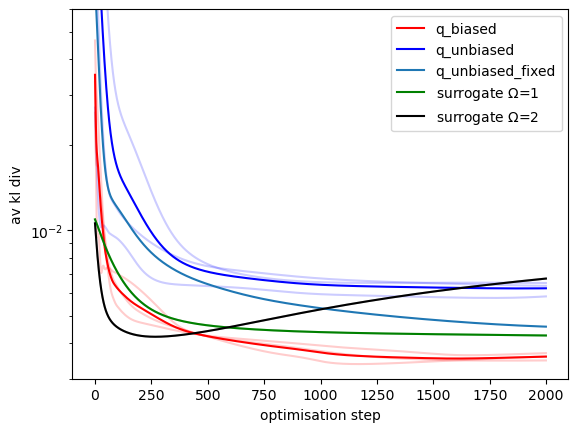

In [30]:
steplist = np.arange(0,n_steps,1)

l = 0
for run in range(n_runs):
    plt.plot(data_q[0][run,:,0],data_q[l][run,:,2],alpha=0.2,color='red')
    plt.plot(data_u[0][run,:,0],data_u[l][run,:,2],alpha=0.2,color='blue')
    plt.plot(data_s[0][run,:,0],data_s[0][run,:,2],alpha=0.2,color='green')
    plt.plot(data_s[1][run,:,0],data_s[1][run,:,2],alpha=0.2,color='black')
    
plt.plot(data_q_av[l][:,0],data_q_av[l][:,2],alpha=1.0,color='red',label=f'q_biased')
plt.plot(data_u_av[l][:,0],data_u_av[l][:,2],alpha=1.0,color='blue',label=f'q_unbiased')

# plt.plot(data_u_fair_av[0][:,0],data_u_fair_av[0][:,2],alpha=1.0,label=f'q_unbiased_fair')
plt.plot(data_u_fixed_av[0][:,0],data_u_fixed_av[0][:,2],alpha=1.0,label=f'q_unbiased_fixed')

plt.plot(data_s_av[0][:,0],data_s_av[0][:,2],alpha=1.0,color='green',label='surrogate $\Omega$=1')

plt.plot(data_s_av[0][:,0],data_s_av[1][:,2],alpha=1.0,color='black',label='surrogate $\Omega$=2')

plt.yscale("log") 
plt.ylim(3e-3, 6e-2)
plt.legend()
plt.xlabel("optimisation step")
plt.ylabel("av kl div")
plt.legend(loc='upper right')
plt.show()


plot the negative log likelihood

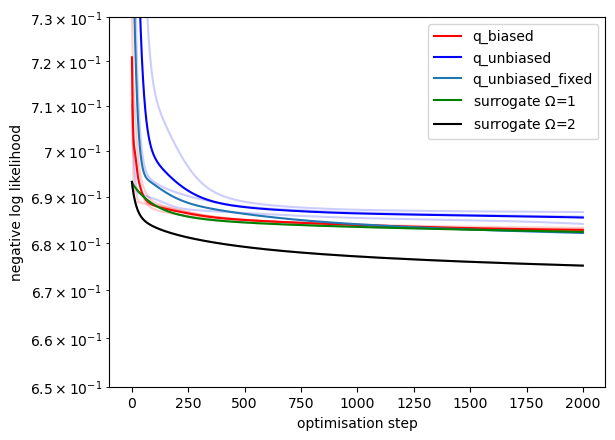

In [31]:
l = 0
for run in range(n_runs):
    plt.plot(data_q[0][run,:,0],data_q[l][run,:,1],alpha=0.2,color='red')
    plt.plot(data_u[0][run,:,0],data_u[l][run,:,1],alpha=0.2,color='blue')
    plt.plot(data_s[0][run,:,0],data_s[0][run,:,1],alpha=0.2,color='green')
    plt.plot(data_s[1][run,:,0],data_s[1][run,:,1],alpha=0.2,color='black')
    
plt.plot(data_q_av[l][:,0],data_q_av[l][:,1],alpha=1.0,color='red',label=f'q_biased')

plt.plot(data_u_av[l][:,0],data_u_av[l][:,1],alpha=1.0,color='blue',label=f'q_unbiased')


# plt.plot(data_u_fair_av[0][:,0],data_u_fair_av[0][:,1],alpha=1.0,label=f'q_unbiased_fair')
plt.plot(data_u_fixed_av[0][:,0],data_u_fixed_av[0][:,1],alpha=1.0,label=f'q_unbiased_fixed')


plt.plot(data_s_av[0][:,0],data_s_av[0][:,1],alpha=1.0,color='green',label='surrogate $\Omega$=1')

plt.plot(data_s_av[0][:,0],data_s_av[1][:,1],alpha=1.0,color='black',label='surrogate $\Omega$=2')

plt.ylim(0.65, 0.73)
plt.yscale("log") 
plt.legend()
plt.xlabel("optimisation step")
plt.ylabel("negative log likelihood")
plt.legend(loc='upper right')
plt.show()